In [26]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/RWMCMC.jl")

emcee_Run

# 2-Parameter Elliptic Equation
Consider the one-dimensional elliptic boundary-value problem

$$
    -\frac{d}{dx}\Big(\exp(\theta_{(1)}) \frac{d}{dx}p(x)\Big) = 1, \qquad x\in[0,1]
$$

with boundary conditions $p(0) = 0$ and $p(1) = \theta_{(2)}$. The solution for this problem is given by  

$$
    p(x) = \theta_{(2)} x + \exp(-\theta_{(1)})\Big(-\frac{x^2}{2} + \frac{x}{2}\Big).
$$

The inverse problem is to solve for $\theta = (\theta_{(1)},\, \theta_{(2)})^T$ with the observations $y = (p(x_1),\,p(x_2))^T$ at $x_1=0.25$ and $x_2=0.75$.
The Bayesian inverse problem is formulated as 

$$
    y = \mathcal{G}(\theta) + \eta \qquad \textrm{and} \qquad 
    \mathcal{G}(\theta) = \begin{bmatrix}
    p(x_1, \theta)\\
    p(x_2, \theta)
    \end{bmatrix},
$$
here $\mathcal{G}(\theta)$ is the forward model operator.   The observation is $y=(27.5, 79.7)^T$ with observation error $\eta\sim\mathcal{N}(0, 0.1^2 I)$. And the prior is $\mathcal{N}(0, 10^2 I)$, which is almost uninformative.

The numerical experiment considered here is a counterexample against the ensemble Kalman filter, which is proposed in [1] and further used in [2,3]. 

1. Ernst, Oliver G and Sprungk, Björn and Starkloff, Hans-Jörg, "Analysis of the ensemble and polynomial chaos Kalman filters in Bayesian inverse problems"

2. Herty, Michael and Visconti, Giuseppe, "Kinetic methods for inverse problems"

3. Garbuno-Inigo, Alfredo and Hoffmann, Franca and Li, Wuchen and Stuart, Andrew M, "Interacting Langevin diffusions: Gradient structure and ensemble Kalman sampler


In [27]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function forward(s_param, θ::Array{Float64,1})
    x1, x2 = 0.25, 0.75
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ; p(x2)]
end


function forward_illposed(s_param, θ::Array{Float64,1})
    x1 = 0.25
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ;]
end

function forward_illposed_augmented(s_param, θ::Array{Float64,1})
    x1 = 0.25
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ; θ1; θ2]
end

forward_illposed_augmented (generic function with 1 method)

# Numerical Methods

The posterior distribution is approximated by 
* MCMC method (reference):  a step size $1.0$ and $5\times10^6$ samples (with a $10^6$ sample burn-in period).
* UKI method: initialized at $\theta_0\sim\mathcal{N}(-1, 0.5^2)$  

In [61]:
function Ellitic_Posterior_Plot(update_freq::Int64 = 1, Σ0::Array{Float64, 2}=[1.0^2  0.0; 0.0 1.0^2])
    # observation and observation error covariance
    y = [27.5;]
    Σ_η = fill(0.1^2, (1,1))
    
    # (uninformative) prior mean and covariance
    μ0 = [0.0; 100.0] 
    
    s_param = Setup_Param(2, 1)
    
    # compute posterior distribution by MCMC
    logρ(θ) = log_bayesian_posterior(s_param, θ, forward_illposed, y, Σ_η, μ0, Σ0)
    step_length = 1.0
    N_iter_MCMC , n_burn_in= 5000000, 1000000

    us = RWMCMC_Run(logρ, μ0, step_length, N_iter_MCMC)
    
    # UKI initialization compute posterior distribution by UKI
    s_param = Setup_Param(2, 3)
    θ0_mean = μ0
    # θθ0_cov = [1.0  0.0; 0.0 1.0]
    θθ0_cov = Σ0
    α_reg,  N_iter = 1.0, 20
    
    ###
    N_iter = 20
    y_augmented = [27.5; μ0[1]; μ0[2]]
    Σ_η_augmented = [0.1^2 0 0; 0 Σ0[1,1] Σ0[1,2]; 0 Σ0[2,1] Σ0[2,2]]
    ukiobj = UKI_Run(s_param, forward_illposed_augmented, θ0_mean, θθ0_cov, y_augmented, Σ_η_augmented, α_reg, update_freq, N_iter, modified_uscented_transform = true)
    
    
    # plot UKI results at 5th, 10th, and 15th iterations
    ncols = 3
    fig, ax = PyPlot.subplots(ncols=ncols, sharex=false, sharey=true, figsize=(15,5))
    for icol = 1:ncols
        # plot UKI results 
        ites = 5*icol
        Nx = 100; Ny = 200
        uki_θ_mean = ukiobj.θ_mean[ites]
        uki_θθ_cov = ukiobj.θθ_cov[ites]
        X,Y,Z = Gaussian_2d(uki_θ_mean, uki_θθ_cov, Nx, Ny)
        ax[icol].contour(X, Y, Z, 50)
        
        # plot MCMC results 
        everymarker = 1
        ax[icol].scatter(us[n_burn_in:everymarker:end, 1], us[n_burn_in:everymarker:end, 2], s = 1)
    end
    
    
    N_θ = 2
    mcmc_θ_mean = sum(us[n_burn_in:end, :], dims = 1)/size(us[n_burn_in:end, :], 1)
    mcmc_θiθj_cov = zeros(Float64, N_θ, N_θ)
    for i = 1:N_θ
        for j = 1:N_θ
            mcmc_θiθj_cov[i, j] = (us[n_burn_in:end, i] .- mcmc_θ_mean[i])' * (us[n_burn_in:end, j] .- mcmc_θ_mean[j])/(N_iter_MCMC - n_burn_in)
        end
    end

    @info "MCMC mean/cov are ", mcmc_θ_mean, mcmc_θiθj_cov
    @info "UKI  mean/cov are ", ukiobj.θ_mean[15], ukiobj.θθ_cov[15]

    fig.tight_layout()
    savefig("Elliptic_UKI_update_cov_$(Int64(Σ0[1,1]))$(Int64(Σ0[2,2])).png")
end


Ellitic_Posterior_Plot (generic function with 3 methods)

For the UKI, the hyperparameters are chosen at the $n$-th iteration, as following
$$ r = r_0 \quad
    \Sigma_{\nu} = 2\Sigma_{\eta} \quad \textrm{ and } \quad \Sigma_{\omega} =  C_n
$$
here $r_0$ is the prior mean. It is worth mentioning the artificial evolution error covariance $\Sigma_{\omega}$ is updated as the estimated covariance $C_{n}$. 

The Gaussian approximations to the posterior distribution at the 5th, 10th and 15th iterations obtained by the UKI are: 

In [62]:
update_freq = 1
Σ0    = [1.0^2  0.0; 0.0 1.0^2]
Ellitic_Posterior_Plot(update_freq, Σ0)

Figure(PyObject <Figure size 1500x500 with 3 Axes>)

┌ Info: ("optimization error at iter 1 = ", 289.50195312499994)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 1.4142135623730951)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 13.253819854505197)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 1.0660258614252733)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 27.90422862000379)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 0.8216734752555398)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 25.377020446242398)
└ @ Main /Users/huang/Desktop/Code/InverseProblem

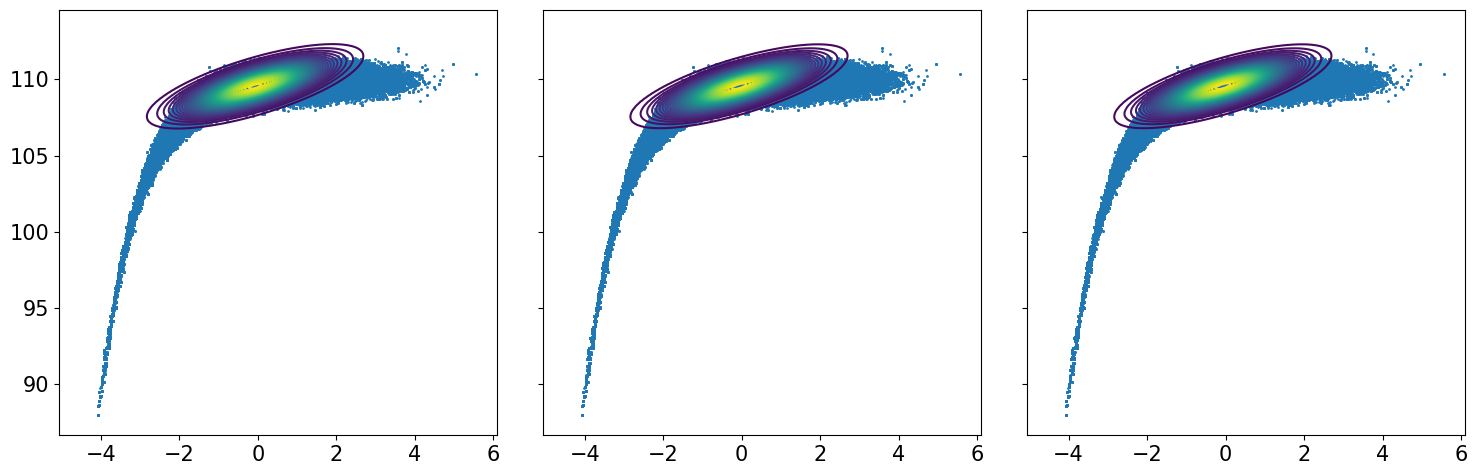

┌ Info: ("optimization error at iter 1 = ", 289.50195312499994)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 100.00499987500625)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 0.48472645819506205)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 1.8937818159841184)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 0.46990052146229533)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 1.7764219367031975)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 0.46681760190542265)
└ @ Main /Users/huang/Desktop/Code/InversePro

In [63]:
update_freq = 1
Σ0    = [1.0^2  0.0; 0.0 10.0^2]
Ellitic_Posterior_Plot(update_freq, Σ0)

For the UKI, the hyperparameters are chosen, as following
$$ r = r_0 \quad
    \Sigma_{\nu} = 2\Sigma_{\eta} \quad \textrm{ and } \quad \Sigma_{\omega} =  C_0
$$
here $r_0$ is the prior mean. And no updating is applied. 

The Gaussian approximations to the posterior distribution at the 5th, 10th and 15th iterations obtained by the UKI are: 

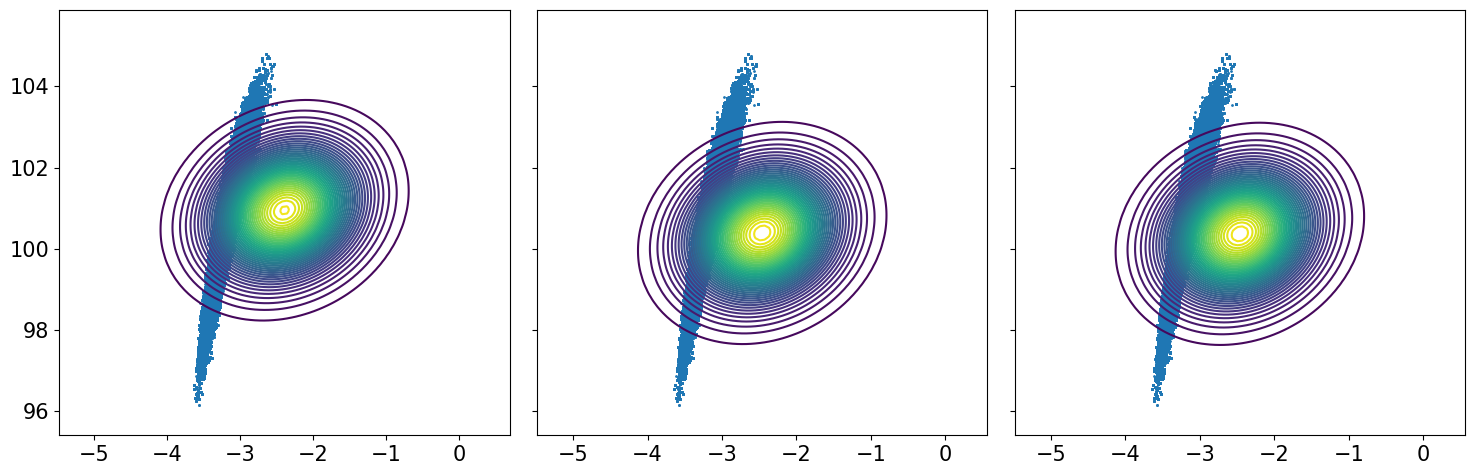

┌ Info: ("optimization error at iter 1 = ", 289.50195312499994)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 1 = ", 1.4142135623730951)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 2 = ", 13.253819854505197)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 2 = ", 1.0660258614252733)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 3 = ", 51.82170229865889)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:302
┌ Info: ("Frobenius norm of the covariance at iter 3 = ", 1.0059683150898175)
└ @ Main /Users/huang/Desktop/Code/InverseProblems-5.jl/Inversion/UKI.jl:303
┌ Info: ("optimization error at iter 4 = ", 76.11922045654738)
└ @ Main /Users/huang/Desktop/Code/InverseProblems

In [64]:
update_freq = 0
Ellitic_Posterior_Plot(update_freq)